PageRank is a link analysis algorithm, operating on a database of documents connected to each other via directional hyperlinks. It was developed to measure the relative importance of a webpage in the World Wide Web, and with minor variations has also been employed in the context of assigning importance to academic journal publications.

Graph-theoretic terminology We will represent a collection of hyperlinked documents (webpages, academic journals, etc.) as a directed graph $G = (V, E)$, where $V$ is the set of documents $\{d_1, \dots, d_N\}$ and the edge set $E \subseteq V \times V$ can be represented by an $N \times N$ adjacency matrix $A$, where $A_{ij} = 1$ if and only if $d_j \rightarrow d_i$ (i.e., if and only if $(d_j , d_i) \in E$). The out-degree of a node $i$ is the number of outgoing edges $d_i \rightarrow d_j$ . A node with out-degree $0$ is called a dangling node. Multiple edges can be incorporated by letting $A_{ij} = d$ when there are $d$ edges $j \rightarrow i$.

PageRank may be motivated as a voting system. Each webpage can distribute a total vote of $1$ to other webpages, and votes themselves are weighted according to the importance of the respective voter, giving rise to the following recursion for the score $w_i$ of the $i$-th webpage:
\begin{equation}
    w_i = \sum_{j=1}^N S_{ij}w_j, \quad \text{where} \quad S_{ij} = \frac{A_{ij}}{\sum_{q=1}^N A_{qj}} \quad \text{and} \quad w_i > 0.
\end{equation}
A normalisation constraint $\sum_i w_i = N$ is also employed, to ensure an average score of $1$. Moreover, we assume that everyone votes, i.e., that there are no dangling nodes. We may interpret $S$ as the transition matrix of a Markov chain that describes the behaviour of a surfer who chooses where to go next by picking one of the available outgoing links at random. Recursion then characterises the score vector $w$ as an invariant measure for this Markov chain.


---

We now exhibit a graph and its corresponding adjacency matrix $A$ that causes the PageRank recursion to oscillate rather than converge when initialised with the vector $w = (1, 1, \dots, 1)$. A simple example that achieves this is a star graph with one central node and two or more outer nodes, where the center points to the outer nodes and the outer nodes point back to the center.

Consider a graph with $3$ nodes with node $1$ at the centre which mutually points to and from node 2 and node 3. The adjacency matrix is
\begin{equation}
    A =
    \begin{pmatrix}
        0 & 1 & 1 \\
        1 & 0 & 0 \\
        1 & 0 & 0
    \end{pmatrix}.
\end{equation}
The transition matrix after normalising $A$ is
\begin{equation}
    S =
    \begin{pmatrix}
        0 & 1 & 1 \\
        0.5 & 0 & 0 \\
        0.5 & 0 & 0
    \end{pmatrix}.
\end{equation}
Note that the everyone votes condition is met because every column sum is non-zero. Initialise with $w^{(0)} = (1, 1, 1)^T$ and iterate by repeatedly applying $S$:
\begin{align}
    w^{(1)} &=
    \begin{pmatrix}
        0 & 1 & 1 \\
        0.5 & 0 & 0 \\
        0.5 & 0 & 0
    \end{pmatrix}
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix} = \begin{pmatrix} 2 \\ 0.5 \\ 0.5 \end{pmatrix} \\
    w^{(2)} &=
    \begin{pmatrix}
        0 & 1 & 1 \\
        0.5 & 0 & 0 \\
        0.5 & 0 & 0
    \end{pmatrix}
    \begin{pmatrix} 2 \\ 0.5 \\ 0.5 \end{pmatrix} = \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}
\end{align}
Thisshows that the system has a period $2$ cycle and the recursion fails to converge. The graph is bipartite so the PageRank iteration alternates shifting the vote mass entirely from one set to the other. Because the sets are of different sizes and the graph is not regular, the distribution of values changes with every step, preventing convergence to a steady state.


---

To avoid having to enforce assumptions on the edge structure of the document collection, we may assume that the surfer occasionally gets bored following links and starts anew, selecting a random webpage from $V$ to visit next according to some default distribution $\pi$ on $V$. This is often referred to as damping. If we handle dangling nodes in a similar way, we obtain the
random surfer model:

*   Random Surfer $[(V, A), \pi, d]$
*   At $t = 0$, choose a random webpage from $V$ according to $\pi$.
*   At $t > 0$, if there are no outgoing links, then:
    *   Choose a random webpage from $V$ according to $\pi$;
*   Else
    *   With probability $d$, choose an outgoing link uniformly at random among available links;
    *   With probability $(1 - d)$, choose a random webpage from $V$ according to $\pi$.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random

NUM_NODES = 4
NUM_PATHS = 100
TIME_STEPS = 1000
DAMPING_FACTOR = 0.85

def get_graph_adjacency():
    '''
    Returns the graph structure based on matrix.
    A_ij = 1 iff j -> i (Column is source, Row is destination).
    Node 0: Links to 1, 2
    Node 1: Links to 0
    Node 2: No outgoing links (Dangling)
    Node 3: Links to 2
    '''
    return {
        0: [1, 2],
        1: [0],
        2: [],
        3: [2]
    }

def get_next_node(current_node, graph, num_nodes, d):
    '''
    Determines the next state of the random surfer.
    '''
    outgoing_links = graph[current_node]

    if not outgoing_links:
        return random.choice(range(num_nodes))

    if random.random() < d:
        return random.choice(outgoing_links)
    else:
        return random.choice(range(num_nodes))

def run_simulation(num_paths, time_steps, graph, num_nodes, d):
    '''
    Simulates N sample paths of the random surfer.
    Returns a matrix of shape (num_paths, time_steps).
    '''
    paths = np.zeros((num_paths, time_steps), dtype=int)

    for i in range(num_paths):
        curr = random.choice(range(num_nodes))
        paths[i, 0] = curr

        for t in range(1, time_steps):
            curr = get_next_node(curr, graph, num_nodes, d)
            paths[i, t] = curr

    return paths

def calculate_statistics(paths, num_nodes):
    '''
    Computes the cumulative average (mu) and the variance across paths.
    '''
    num_paths, time_steps = paths.shape
    mu_values = np.zeros((num_paths, time_steps, num_nodes))

    # Calculate cumulative average for each node
    for k in range(num_nodes):
        # Mask 1 if surfer is at node k, 0 otherwise
        is_node_k = (paths == k)

        # Count cumulative visits up to time t
        cumulative_visits = np.cumsum(is_node_k, axis=1)

        # Divide by time index (1, 2, ..., T) to get average
        time_indices = np.arange(1, time_steps + 1)
        mu_values[:, :, k] = cumulative_visits / time_indices

    # Calculate variance across the sample paths
    variances = np.var(mu_values, axis=0)

    return mu_values, variances

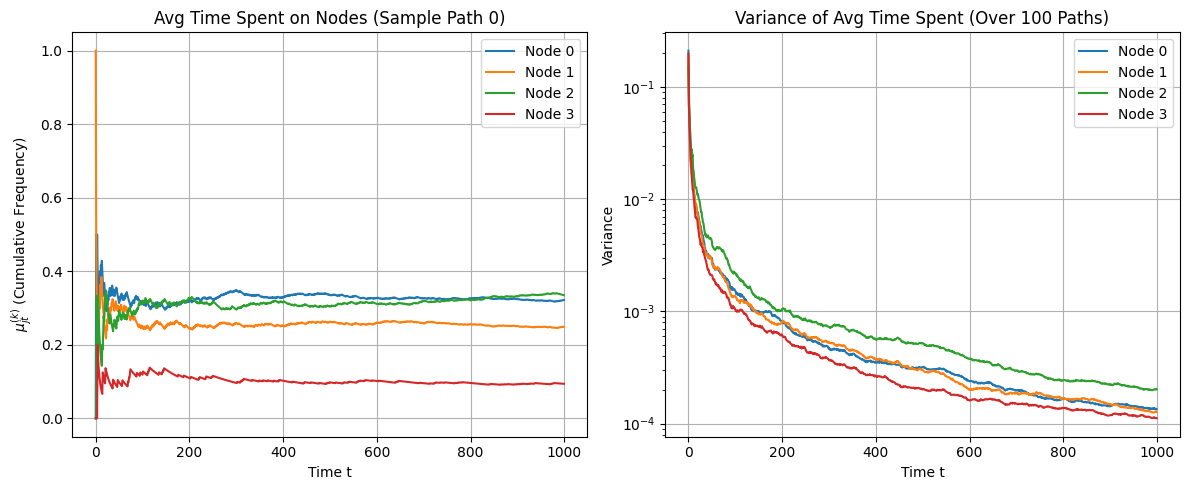

In [21]:
def plot_results(mu_values, variances, num_nodes, path_index_to_plot=0):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    time_axis = range(mu_values.shape[1])

    ax1 = axes[0]
    for k in range(num_nodes):
        ax1.plot(time_axis, mu_values[path_index_to_plot, :, k], label=f'Node {k}')

    ax1.set_title(f'Avg Time Spent on Nodes (Sample Path {path_index_to_plot})')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel(r'$\mu_{jt}^{(k)}$ (Cumulative Frequency)')
    ax1.legend()
    ax1.grid(True)

    ax2 = axes[1]
    for k in range(num_nodes):
        ax2.plot(time_axis, variances[:, k], label=f'Node {k}')

    ax2.set_title(f'Variance of Avg Time Spent (Over {NUM_PATHS} Paths)')
    ax2.set_xlabel('Time t')
    ax2.set_ylabel('Variance')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

graph = get_graph_adjacency()
path_history = run_simulation(NUM_PATHS, TIME_STEPS, graph, NUM_NODES, DAMPING_FACTOR)
mu_data, var_data = calculate_statistics(path_history, NUM_NODES)
plot_results(mu_data, var_data, NUM_NODES)

Each line of $\mu_{jt}^{(k)}$ for a single simulation run represent the running average of how often the surfer visits each node. As $t$ increases, these lines will stabilise on the PageRank values for the nodes. Node $0$ has the highest value, then nodes $1$ and $2$ and finally node $3$ which reflects the number of incoming linkes from within the graph. Indeed, node 3 only gets visits from random jumps or restarts.
    
At small $t$, the variance is high because the surfer's location is highly dependent on the random starting point and the first few random choices. As $t$ increases, the variance will decrease (approaching zero). This confirms the Ergodic theorem which states that as the simulation runs longer, the proportion of time spent on a node converges to the theoretical probability, independent of the starting path.

---

Let $p^{(t)}$ be the probability distribution vector at step $t$, where $p_i^{(t)}$ is the probability that the surfer is at node $i$. We construct the transition matrix $M$ based on the random surfer model. The probability of moving from node $j$ to node $i$, denoted $M_{ij}$, is defined by two cases:

*   If node $j$ is a dangling node, $k_j = 0$, then the surfer chooses the next page from the distribution $\pi$.
    \begin{equation}
        M_{ij} = \pi_i
    \end{equation}
*   If node $j$ is not dangling, $k_j > 0$, then
    *   With probability $d$, the surfer chooses an outgoing link uniformly, probability $1/k_j$ if linked and $0$ otherwise.
    *   With probability $(1-d)$, the surfer chooses the next page from $\pi$.

    \begin{equation}
        M_{ij} = d\frac{A_{ij}}{k_j} + (1-d)\pi_i
    \end{equation}

Combining these, the modified recursion for the probability vector $p$ is
\begin{equation}
    p_i^{(t+1)} = \sum_{j=1}^{N} M_{ij} p_j^{(t)},
\end{equation}
or in matrix notation, $p^{(t+1)} = M p^{(t)}$.

We now show that $M$ is a strictly positive stochastic matrix.

If $j$ is dangling, then $\sum_i M_{ij} = \sum_i \pi_i = 1$. If $j$ is not dangling, then
\begin{equation}
    \sum_i M_{ij} = \sum_i \left(d \frac{A_{ij}}{k_j} + (1-d)\pi_i\right) = 1.
\end{equation}
Furthermore, as $\pi_i > 0$ for all $i$ and $0 < d < 1$, we have if $j$ is dangling, then $M_{ij} = \pi_i > 0$. If $j$ is non-dangling, then since $A_{ij} \geq 0$, we have $M_{ij} \geq (1-d)\pi_i$, hence $M_{ij} > 0$. Therefore all entries of $M$ are strictly positive.

The associated Markov chain is regular, i.e. irreducible (every state can reach every other state in one step) and aperiodic (every state has a self-loop preventing fixed cycles).

By the Perron-Frobenius theorem, there exists a unique stationary distribution vector $p$ such that $Mp = p$, $\sum p_i = 1$, and $p_i > 0$. By the Ergodic theorem for an irreducible chain, the stationary probability $p_i$ represents the long-run fraction of time the process spends in state $i$. Furthermore, for any initial probability distribution $p^{(0)}$, the sequence $p^{(t+1)} = M p^{(t)}$ converges to the unique vector $p$ as $t \to \infty$,
\begin{equation}
    \lim_{t \to \infty} M^t p^{(0)} = p.
\end{equation}
The final PageRank scores are then given by scaling this distribution $w = Np$.

In [22]:
def calculate_pagerank(adj_matrix, max_iterations=100, d=0.85):
    '''
    Computes PageRank scores for a given adjacency matrix.
    Args:
        adj_matrix: NxN matrix A where A_ij = 1 if there is a link from j to i.
        max_iterations: Number of iterations to perform.
        d: Damping factor (default 0.85).
    Returns:
        Column vector of PageRank scores (summing to N).
    '''
    N = adj_matrix.shape[0]

    # Construct the transition matrix M
    M = np.zeros((N, N))
    col_sums = np.sum(adj_matrix, axis=0)

    for j in range(N):
        if col_sums[j] == 0:
            # Dangling node: distributes probability evenly to all nodes
            M[:, j] = 1.0 / N
        else:
            # Normal node: distributes d proportional to links, (1-d) uniform
            # A[:, j] is the column representing links FROM node j
            link_probs = adj_matrix[:, j] / col_sums[j]
            M[:, j] = d * link_probs + (1 - d) / N

    # Initialise the state vector p (uniform distribution)
    p = np.ones(N) / N

    # Iterate
    for _ in range(max_iterations):
        p = np.dot(M, p)

    # Normalise score to sum to N
    w = p * N
    return w

A = np.array([
    [0, 1, 0, 0],  # Links to Node 0 (from 1)
    [1, 0, 0, 0],  # Links to Node 1 (from 0)
    [1, 0, 0, 1],  # Links to Node 2 (from 0, 3)
    [0, 0, 0, 0]   # Links to Node 3 (none)
])

scores_q2 = calculate_pagerank(A)
print(A)
for i, score in enumerate(scores_q2):
    print(f"Node {i}: {score:.4f}")

B = np.array([
    [0, 1, 1, 0, 0],  # Links to Node 0 (from 1, 2)
    [0, 0, 0, 1, 1],  # Links to Node 1 (from 3, 4)
    [1, 0, 0, 0, 0],  # Links to Node 2 (from 0)
    [0, 1, 0, 0, 0],  # Links to Node 3 (from 1)
    [0, 1, 0, 0, 0]   # Links to Node 4 (from 1)
])

scores_b = calculate_pagerank(B)
print(f"\n{B}")
print(f"Node 1 (In: 2, Out: 3) Score: {scores_b[1]:.4f}")
print(f"Node 2 (In: 1, Out: 1) Score: {scores_b[2]:.4f}")
print("Node 2 has a higher score despite fewer links due to higher ranked links.")

[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 1]
 [0 0 0 0]]
Node 0: 1.2581
Node 1: 0.9691
Node 2: 1.3383
Node 3: 0.4344

[[0 1 1 0 0]
 [0 0 0 1 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
Node 1 (In: 2, Out: 3) Score: 0.7814
Node 2 (In: 1, Out: 1) Score: 1.6781
Node 2 has a higher score despite fewer links due to higher ranked links.


In [30]:
def generate_poisson_adjacency(N, k):
    '''
    Generates a random adjacency matrix where out-degrees are Poisson(k).
    Destinations are chosen uniformly at random.
    '''
    # Initialise empty matrix
    A = np.zeros((N, N))

    # Generate out-degrees for all N nodes
    out_degrees = np.random.poisson(k, N)

    for j in range(N):
        num_links = out_degrees[j]
        if num_links > 0:
            # Choose destinations uniformly with replacement
            destinations = np.random.randint(0, N, num_links)
            # Fill matrix (Column j is source)
            # We accumulate links (A_ij = count of edges j->i)
            for i in destinations:
                A[i, j] += 1

    return A

def get_google_matrix(adj_matrix, d=0.85):
    '''
    Constructs the stochastic transition matrix M (Google Matrix).
    '''
    N = adj_matrix.shape[0]
    M = np.zeros((N, N))
    col_sums = np.sum(adj_matrix, axis=0)

    # Transition probability matrix S (handling dangling nodes)
    S = np.zeros((N, N))
    for j in range(N):
        if col_sums[j] == 0:
            S[:, j] = 1.0 / N
        else:
            S[:, j] = adj_matrix[:, j] / col_sums[j]

    # Apply damping to get M
    # M = d * S + (1-d) * E, where E is 1/N everywhere
    E = (1.0 / N) * np.ones((N, N))
    M = d * S + (1 - d) * E
    return M

N = 1000
k = 100
d = 0.85
A = generate_poisson_adjacency(N, k)

# Iterative Power Method
# (Re-implementing briefly for completeness)
p_iter = np.ones(N) / N
M = get_google_matrix(A, d)
for _ in range(100):
    p_iter = np.dot(M, p_iter)
w_iter = p_iter * N

# Eigenvector Decomposition
eigenvalues, eigenvectors = np.linalg.eig(M)

# Find the index of the eigenvalue closest to 1
idx = np.argmin(np.abs(eigenvalues - 1))
largest_eigenvalue = eigenvalues[idx]

# Extract corresponding eigenvector (take real part to remove numerical noise)
p_eigen = np.real(eigenvectors[:, idx])

# Normalise sum(p) = 1, then scale to sum(w) = N.
p_eigen = p_eigen / np.sum(p_eigen)
w_eigen = p_eigen * N

difference = np.linalg.norm(w_iter - w_eigen)
print(f"Difference between Iterative and Eigenvector scores: {difference:.10f}")

Difference between Iterative and Eigenvector scores: 0.0000000000


The PageRank vector $p$ is defined as the stationary distribution of the Markov chain defined by the Google Matrix $M$. This satisfies the equation:
\begin{equation}
    M p = 1 \cdot p
\end{equation}
This equation states that $p$ is an eigenvector of matrix $M$ corresponding to the eigenvalue $\lambda = 1$. Because $M$ is a positive stochastic matrix (due to damping and handling dangling nodes), the Perron-Frobenius theorem guarantees that the largest eigenvalue has magnitude $1$ and its corresponding eigenvector is unique (up to scaling) and consists entirely of real, positive numbers.

When $k$ is large, the graph is dense and the random conections are well-distributed. By the CLT, the in-degree distribution and PageRank scores will approximate a normal distribution. The variance should be relatively low as most pages have "average" importance.

When $k$ is small, the graph is more sparse. The distribution of outgoing edges is Poisson, but the resulting incoming edges also follow a Poisson distribution. For small $k$, the Poisson distribution is highly skewed to the right. Many nodes will have $0$ incoming links and few nodes will have a low number of links, making them exponentially more important than the zeros. The distribution of scores is now exponentially decaying.

The most significant inaccuracy of the model is the degree distribution. In a Poisson graph, the probability of a node having a very high degree decays exponentially. Real-world networks follow a power law distribution where the probability of having degree $k$ is proportional to $k^{-\gamma}$. This leads to a heavy-tailed distribution which form the backbone of the network.